In [1]:
"""
Benchmarking utilities for linear solvers.
"""
import numpy as np
import scipy
import scipy.sparse
import time
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Callable, Tuple, Optional, Union

from linear_solvers import (
    LinearSolver, CGLSSolver, LSQRSolver, RRLSQRSolver, RRLSSolver,
    direct_solver, TikhonvRegularization, get_optimal_solver
)


def generate_test_problem(n: int, m: Optional[int] = None, 
                        condition: float = 10.0,
                        density: float = 1.0,
                        symmetric: bool = False,
                        positive_definite: bool = False,
                        sparse: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a test linear system Ax = b with known solution.
    
    Args:
        n: Number of rows in A
        m: Number of columns in A (default: n)
        condition: Condition number of A
        density: Density of A (for sparse matrices)
        symmetric: Whether A should be symmetric
        positive_definite: Whether A should be positive definite
        sparse: Whether A should be sparse
        
    Returns:
        Tuple of (A, b, x_true)
    """
    if m is None:
        m = n
    
    if symmetric and m != n:
        raise ValueError("Symmetric matrices must be square")
    
    if positive_definite and not symmetric:
        symmetric = True
    
    # Generate the true solution
    x_true = np.random.randn(m)
    
    # Generate matrix with desired properties
    if symmetric:
        if positive_definite:
            # Generate SPD matrix with given condition number
            eigs = np.logspace(0, np.log10(condition), m)
            Q, _ = np.linalg.qr(np.random.randn(m, m))
            A = Q @ np.diag(eigs) @ Q.T
        else:
            # Generate symmetric matrix with given condition number
            eigs = np.logspace(0, np.log10(condition), m)
            eigs *= np.random.choice([-1, 1], size=m)
            Q, _ = np.linalg.qr(np.random.randn(m, m))
            A = Q @ np.diag(eigs) @ Q.T
    else:
        # Generate general matrix with given condition number
        if n == m:
            # Square matrix
            U, _ = np.linalg.qr(np.random.randn(n, n))
            V, _ = np.linalg.qr(np.random.randn(m, m))
            eigs = np.logspace(0, np.log10(condition), min(n, m))
            if n > m:
                eigs = np.concatenate([eigs, np.zeros(n - m)])
            A = U @ np.diag(eigs) @ V.T
        else:
            # Rectangular matrix
            U, _ = np.linalg.qr(np.random.randn(n, n))
            V, _ = np.linalg.qr(np.random.randn(m, m))
            eigs = np.logspace(0, np.log10(condition), min(n, m))
            if n > m:
                S = np.zeros((n, m))
                S[:m, :] = np.diag(eigs)
            else:
                S = np.zeros((n, m))
                S[:, :n] = np.diag(eigs)
            A = U @ S @ V.T
    
    # Convert to sparse if requested
    if sparse and density < 1.0:
        if symmetric:
            # Ensure sparsity pattern remains symmetric
            mask = scipy.sparse.random(m, m, density=np.sqrt(density))
            mask = mask + mask.T
            mask.data[:] = 1
            A = scipy.sparse.csr_matrix(A) * mask
        else:
            # Random sparsity pattern
            mask = scipy.sparse.random(n, m, density=density)
            mask.data[:] = 1
            A = scipy.sparse.csr_matrix(A) * mask
    elif sparse:
        # Convert to sparse with full density
        A = scipy.sparse.csr_matrix(A)
    
    # Generate right-hand side
    b = A @ x_true
    
    return A, b, x_true


def benchmark_solver(solver: Union[Callable, LinearSolver], 
                    A: np.ndarray, 
                    b: np.ndarray, 
                    x_true: np.ndarray,
                    name: str = "Solver") -> Dict[str, Any]:
    """
    Benchmark a linear solver on a test problem.
    
    Args:
        solver: Linear solver function or object
        A: System matrix
        b: Right-hand side vector
        x_true: True solution
        name: Name of the solver
        
    Returns:
        Dictionary with benchmark results
    """
    # Start timer
    start_time = time.time()
    
    # Solve the system
    if callable(solver):
        x = solver(A, b)
    else:
        x = solver.solve(A, b)
    
    # End timer
    end_time = time.time()
    
    # Calculate error metrics
    residual_norm = np.linalg.norm(A @ x - b)
    error_norm = np.linalg.norm(x - x_true)
    relative_error = error_norm / np.linalg.norm(x_true)
    
    # Return results
    return {
        "name": name,
        "time": end_time - start_time,
        "residual_norm": residual_norm,
        "error_norm": error_norm,
        "relative_error": relative_error,
        "solution": x
    }


def run_solver_comparison(solvers: List[Union[Callable, LinearSolver]], 
                        solver_names: List[str],
                        problem_sizes: List[int],
                        repetitions: int = 3,
                        **problem_params) -> Dict[str, Any]:
    """
    Compare multiple solvers on test problems of different sizes.
    
    Args:
        solvers: List of solver functions or objects
        solver_names: List of solver names
        problem_sizes: List of problem sizes to test
        repetitions: Number of repetitions for each test
        **problem_params: Additional parameters for generate_test_problem
        
    Returns:
        Dictionary with comparison results
    """
    if len(solvers) != len(solver_names):
        raise ValueError("Number of solvers must match number of names")
    
    results = {
        "sizes": problem_sizes,
        "solvers": solver_names,
        "times": [[] for _ in solvers],
        "errors": [[] for _ in solvers],
        "residuals": [[] for _ in solvers]
    }
    
    for size in problem_sizes:
        print(f"Testing problem size {size}...")
        
        size_times = [[] for _ in solvers]
        size_errors = [[] for _ in solvers]
        size_residuals = [[] for _ in solvers]
        
        for rep in range(repetitions):
            print(f"  Repetition {rep+1}/{repetitions}")
            
            # Generate test problem
            A, b, x_true = generate_test_problem(size, **problem_params)
            
            # Run each solver
            for i, (solver, name) in enumerate(zip(solvers, solver_names)):
                try:
                    print(f"    Testing {name}...")
                    result = benchmark_solver(solver, A, b, x_true, name)
                    
                    size_times[i].append(result["time"])
                    size_errors[i].append(result["relative_error"])
                    size_residuals[i].append(result["residual_norm"])
                    
                    print(f"    {name}: time={result['time']:.4f}s, error={result['relative_error']:.4e}")
                except Exception as e:
                    print(f"    {name} failed: {str(e)}")
                    size_times[i].append(np.nan)
                    size_errors[i].append(np.nan)
                    size_residuals[i].append(np.nan)
        
        # Store average results for this size
        for i in range(len(solvers)):
            results["times"][i].append(np.nanmean(size_times[i]))
            results["errors"][i].append(np.nanmean(size_errors[i]))
            results["residuals"][i].append(np.nanmean(size_residuals[i]))
    
    return results


def plot_comparison_results(results: Dict[str, Any], title: str = "Solver Comparison"):
    """
    Plot the results of a solver comparison.
    
    Args:
        results: Results dictionary from run_solver_comparison
        title: Title for the plot
    """
    sizes = results["sizes"]
    solvers = results["solvers"]
    times = results["times"]
    errors = results["errors"]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot computation time
    for i, solver_name in enumerate(solvers):
        ax1.loglog(sizes, times[i], 'o-', label=solver_name)
    
    ax1.set_xlabel("Problem Size (n)")
    ax1.set_ylabel("Computation Time (s)")
    ax1.set_title("Computation Time vs. Problem Size")
    ax1.grid(True)
    ax1.legend()
    
    # Plot relative error
    for i, solver_name in enumerate(solvers):
        ax2.loglog(sizes, errors[i], 'o-', label=solver_name)
    
    ax2.set_xlabel("Problem Size (n)")
    ax2.set_ylabel("Relative Error")
    ax2.set_title("Relative Error vs. Problem Size")
    ax2.grid(True)
    ax2.legend()
    
    # Set overall title
    fig.suptitle(title)
    fig.tight_layout()
    
    return fig


def test_optimal_solver():
    """
    Test the get_optimal_solver function on various problem types.
    """
    problem_types = [
        {"name": "Small Dense Well-conditioned", 
         "params": {"n": 100, "condition": 10.0, "sparse": False}},
        {"name": "Small Dense Ill-conditioned", 
         "params": {"n": 100, "condition": 1e6, "sparse": False}},
        {"name": "Small Sparse Well-conditioned", 
         "params": {"n": 100, "condition": 10.0, "sparse": True, "density": 0.1}},
        {"name": "Large Sparse", 
         "params": {"n": 1000, "sparse": True, "density": 0.01}},
        {"name": "Rectangular Overdetermined", 
         "params": {"n": 200, "m": 100, "sparse": False}},
        {"name": "Rectangular Underdetermined", 
         "params": {"n": 100, "m": 200, "sparse": False}},
        {"name": "SPD Matrix", 
         "params": {"n": 100, "symmetric": True, "positive_definite": True, "sparse": False}},
        {"name": "Symmetric Matrix", 
         "params": {"n": 100, "symmetric": True, "positive_definite": False, "sparse": False}}
    ]
    
    results = []
    
    for problem in problem_types:
        print(f"Testing {problem['name']}...")
        
        # Generate test problem
        A, b, x_true = generate_test_problem(**problem["params"])
        
        # Get optimal solver
        solver, info = get_optimal_solver(A, b)
        
        # Benchmark solver
        try:
            if callable(solver):
                result = benchmark_solver(solver, A, b, x_true, "Optimal")
            else:
                result = benchmark_solver(solver.solve, A, b, x_true, "Optimal")
                
            results.append({
                "problem": problem["name"],
                "solver_info": info,
                "time": result["time"],
                "error": result["relative_error"]
            })
            
            print(f"  Selected solver: {info['type']}")
            print(f"  Time: {result['time']:.4f}s, Error: {result['relative_error']:.4e}")
        except Exception as e:
            print(f"  Solver failed: {str(e)}")
            results.append({
                "problem": problem["name"],
                "solver_info": info,
                "error": "Solver failed"
            })
    
    return results




Running solver benchmark...
Testing problem size 10...
  Repetition 1/3
    Testing Direct...
    Direct: time=0.0061s, error=4.8261e-15
    Testing CGLS...
    CGLS: time=0.0013s, error=4.1545e+00
    Testing LSQR...
    LSQR: time=0.0000s, error=4.1546e+00
    Testing RRLSQR...
    RRLSQR: time=0.0027s, error=4.1646e+00
  Repetition 2/3
    Testing Direct...
    Direct: time=0.0009s, error=2.7443e-14
    Testing CGLS...
    CGLS: time=0.0005s, error=4.1207e+00
    Testing LSQR...
    LSQR: time=0.0005s, error=4.1202e+00
    Testing RRLSQR...
    RRLSQR: time=0.0020s, error=4.1263e+00
  Repetition 3/3
    Testing Direct...
    Direct: time=0.0000s, error=1.1464e-14
    Testing CGLS...
    CGLS: time=0.0000s, error=4.4433e+00
    Testing LSQR...
    LSQR: time=0.0008s, error=4.4433e+00
    Testing RRLSQR...
    RRLSQR: time=0.0020s, error=4.4496e+00
Testing problem size 50...
  Repetition 1/3
    Testing Direct...
    Direct: time=0.0027s, error=2.7967e-14
    Testing CGLS...
    CGLS:

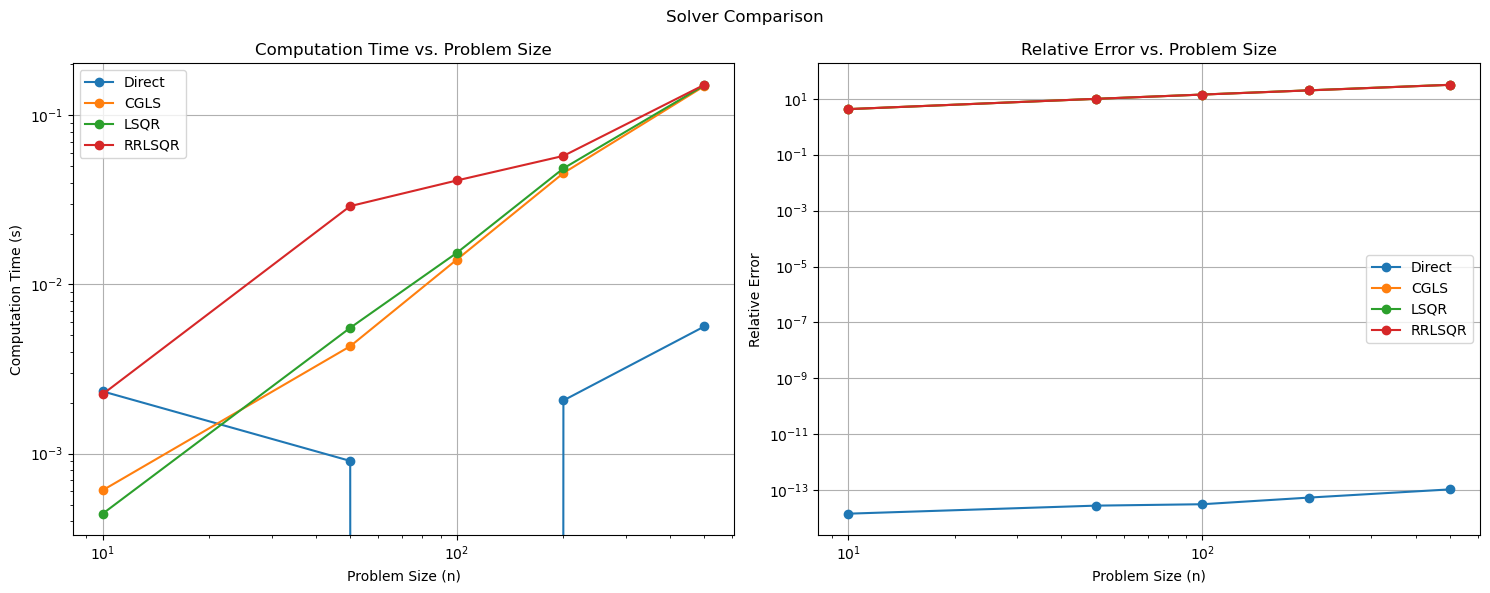

In [2]:

# Example usage
print("Running solver benchmark...")

# Define solvers to compare
solvers = [
    direct_solver,
    CGLSSolver(max_iterations=1000).solve,
    LSQRSolver(max_iterations=1000).solve,
    RRLSQRSolver(max_iterations=1000).solve
]

solver_names = ["Direct", "CGLS", "LSQR", "RRLSQR"]

# Run comparison for different problem sizes
results = run_solver_comparison(
    solvers,
    solver_names,
    problem_sizes=[10, 50, 100, 200, 500],
    repetitions=3,
    condition=1e3,
    sparse=False
)

# Plot results
fig = plot_comparison_results(results)
fig.savefig("solver_comparison.png", dpi=300)

# Test optimal solver selection
optimal_results = test_optimal_solver()

# Print optimal solver results
print("\nOptimal Solver Results:")
for result in optimal_results:
    print(f"Problem: {result['problem']}")
    print(f"  Solver: {result['solver_info']}")
    if isinstance(result['error'], str):
        print(f"  Result: {result['error']}")
    else:
        print(f"  Time: {result['time']:.4f}s, Error: {result['error']:.4e}")
    print()